# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

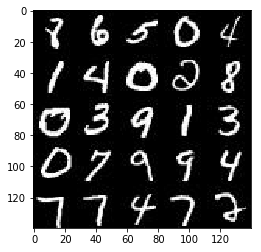

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

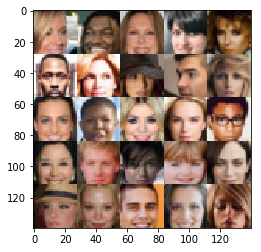

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0


/Users/manopaul/anaconda/envs/deep-learning/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, shape=(None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, shape=(), name='learning_rate')
    return inputs_real, inputs_z, lr 

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.01
    with tf.variable_scope('discriminator', reuse=reuse):
        # 28x28x3 - starting image dimensions
        d_layer1 = tf.layers.conv2d(images, 64,5, strides=2, padding='SAME')
        relu1 = tf.maximum(alpha * d_layer1, d_layer1)
        # 14x14x64
        
        d_layer2 = tf.layers.conv2d(d_layer1, 128, 5, strides=2, padding='SAME')
        bn2 = tf.layers.batch_normalization(d_layer2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        d_layer3 = tf.layers.conv2d(d_layer2, 256, 5, strides=2, padding='SAME')
        bn3 = tf.layers.batch_normalization(d_layer3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    alpha = 0.01
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        g_layer1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        g_layer1 = tf.reshape(g_layer1, (-1, 7,7,256))
        g_layer1 = tf.layers.batch_normalization(g_layer1, training=is_train)
        g_layer1 = tf.maximum(alpha * g_layer1, g_layer1)
        # 7x7x256
        
        g_layer2 = tf.layers.conv2d_transpose(g_layer1, 128, 5, strides=2, padding='SAME')
        g_layer2 = tf.layers.batch_normalization(g_layer2, training=is_train)
        g_layer2 = tf.maximum(alpha * g_layer2, g_layer2)
        # 14x14x128
        
        g_layer3 = tf.layers.conv2d_transpose(g_layer2, 64, 5, strides=2, padding='SAME')
        g_layer3 = tf.layers.batch_normalization(g_layer3, training=is_train)
        g_layer3 = tf.maximum(alpha * g_layer3, g_layer3)
        # 28x28x64
        
        # Output layer
        logits = tf.layers.conv2d_transpose(g_layer3, out_channel_dim, 5, strides=1, padding='SAME')
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    data_image_mode="RGB"
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_depth = data_shape[3]
    
    input_real, input_z, lr = model_inputs(image_width, image_height, image_depth, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_depth)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    saver = tf.train.Saver()
    
    samples, losses = [], []
    steps = 0
    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2
                steps += 1
                
                # Sample random noise for Generator
                batch_z = np.random.uniform(-1,1,size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                
                if steps % print_every == 0:
                    # Print losses at end of each epoch
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    if image_depth == 1:
                            data_image_mode= "L"
                    show_generator_output(sess, 10, input_z, image_depth, data_image_mode)
        
        saver.save(sess, './checkpoints/generator.ckpt')

    return losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0047... Generator Loss: 9.7510
Epoch 1/2... Discriminator Loss: 0.0001... Generator Loss: 12.9565
Epoch 1/2... Discriminator Loss: 0.0294... Generator Loss: 15.9302
Epoch 1/2... Discriminator Loss: 0.0117... Generator Loss: 4.6052
Epoch 1/2... Discriminator Loss: 0.0001... Generator Loss: 10.9973
Epoch 1/2... Discriminator Loss: 0.0843... Generator Loss: 7.1304
Epoch 1/2... Discriminator Loss: 0.0479... Generator Loss: 6.2267
Epoch 1/2... Discriminator Loss: 0.0091... Generator Loss: 6.2532
Epoch 1/2... Discriminator Loss: 0.3153... Generator Loss: 2.4422
Epoch 1/2... Discriminator Loss: 0.0586... Generator Loss: 4.4841


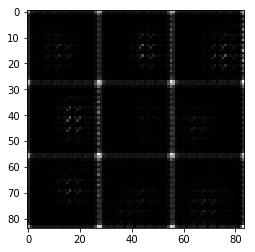

Epoch 1/2... Discriminator Loss: 0.5707... Generator Loss: 9.8135
Epoch 1/2... Discriminator Loss: 0.0085... Generator Loss: 7.2470
Epoch 1/2... Discriminator Loss: 0.0169... Generator Loss: 5.3903
Epoch 1/2... Discriminator Loss: 0.0119... Generator Loss: 5.7154
Epoch 1/2... Discriminator Loss: 0.0090... Generator Loss: 5.9656
Epoch 1/2... Discriminator Loss: 0.0053... Generator Loss: 5.9394
Epoch 1/2... Discriminator Loss: 0.0128... Generator Loss: 5.8929
Epoch 1/2... Discriminator Loss: 0.0039... Generator Loss: 5.9820
Epoch 1/2... Discriminator Loss: 0.0720... Generator Loss: 3.4488
Epoch 1/2... Discriminator Loss: 0.0734... Generator Loss: 3.5090


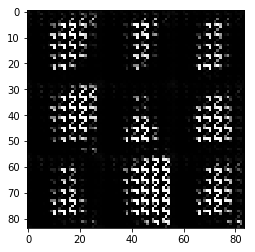

Epoch 1/2... Discriminator Loss: 0.0083... Generator Loss: 5.3223
Epoch 1/2... Discriminator Loss: 0.4908... Generator Loss: 3.3948
Epoch 1/2... Discriminator Loss: 0.5515... Generator Loss: 2.3009
Epoch 1/2... Discriminator Loss: 0.2483... Generator Loss: 3.6371
Epoch 1/2... Discriminator Loss: 2.7362... Generator Loss: 5.5665
Epoch 1/2... Discriminator Loss: 0.9360... Generator Loss: 0.9392
Epoch 1/2... Discriminator Loss: 0.1857... Generator Loss: 3.8433
Epoch 1/2... Discriminator Loss: 0.0846... Generator Loss: 3.2448
Epoch 1/2... Discriminator Loss: 0.6781... Generator Loss: 3.5788
Epoch 1/2... Discriminator Loss: 0.7296... Generator Loss: 1.4538


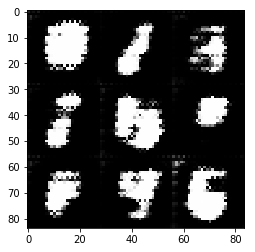

Epoch 1/2... Discriminator Loss: 0.7350... Generator Loss: 2.6684
Epoch 1/2... Discriminator Loss: 1.0053... Generator Loss: 1.4425
Epoch 1/2... Discriminator Loss: 0.5080... Generator Loss: 1.9299
Epoch 1/2... Discriminator Loss: 1.0404... Generator Loss: 2.4228
Epoch 1/2... Discriminator Loss: 1.0058... Generator Loss: 0.7929
Epoch 1/2... Discriminator Loss: 0.9036... Generator Loss: 0.7935
Epoch 1/2... Discriminator Loss: 0.9881... Generator Loss: 2.0391
Epoch 1/2... Discriminator Loss: 0.8339... Generator Loss: 1.0204
Epoch 1/2... Discriminator Loss: 1.2969... Generator Loss: 0.5647
Epoch 1/2... Discriminator Loss: 1.0569... Generator Loss: 0.9149


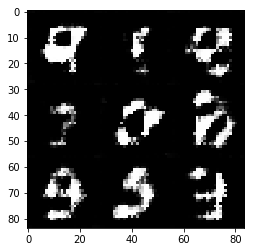

Epoch 1/2... Discriminator Loss: 1.0125... Generator Loss: 1.0412
Epoch 1/2... Discriminator Loss: 1.2905... Generator Loss: 0.5944
Epoch 1/2... Discriminator Loss: 1.0170... Generator Loss: 0.8108
Epoch 1/2... Discriminator Loss: 0.7216... Generator Loss: 1.2942
Epoch 1/2... Discriminator Loss: 0.7874... Generator Loss: 1.2115
Epoch 1/2... Discriminator Loss: 0.8177... Generator Loss: 1.7215
Epoch 1/2... Discriminator Loss: 1.0289... Generator Loss: 1.1101
Epoch 1/2... Discriminator Loss: 2.2478... Generator Loss: 0.1948
Epoch 1/2... Discriminator Loss: 1.0741... Generator Loss: 0.9076
Epoch 1/2... Discriminator Loss: 0.9787... Generator Loss: 1.0135


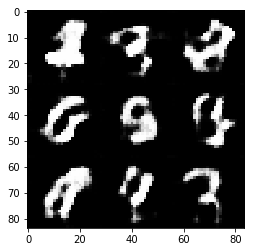

Epoch 1/2... Discriminator Loss: 0.9343... Generator Loss: 1.0414
Epoch 1/2... Discriminator Loss: 0.8897... Generator Loss: 1.1499
Epoch 1/2... Discriminator Loss: 0.9937... Generator Loss: 1.0838
Epoch 1/2... Discriminator Loss: 1.4367... Generator Loss: 0.6064
Epoch 1/2... Discriminator Loss: 1.0556... Generator Loss: 1.2501
Epoch 1/2... Discriminator Loss: 1.1387... Generator Loss: 0.8233
Epoch 1/2... Discriminator Loss: 1.1440... Generator Loss: 1.2075
Epoch 1/2... Discriminator Loss: 1.0936... Generator Loss: 1.0939
Epoch 1/2... Discriminator Loss: 1.1842... Generator Loss: 0.9388
Epoch 1/2... Discriminator Loss: 1.0882... Generator Loss: 1.1147


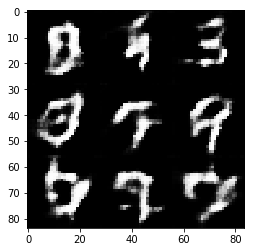

Epoch 1/2... Discriminator Loss: 1.1684... Generator Loss: 0.9406
Epoch 1/2... Discriminator Loss: 1.0791... Generator Loss: 1.0109
Epoch 1/2... Discriminator Loss: 1.1214... Generator Loss: 1.0876
Epoch 1/2... Discriminator Loss: 1.1472... Generator Loss: 0.8429
Epoch 1/2... Discriminator Loss: 1.2573... Generator Loss: 0.7171
Epoch 1/2... Discriminator Loss: 1.1394... Generator Loss: 0.8804
Epoch 1/2... Discriminator Loss: 1.0838... Generator Loss: 0.8953
Epoch 1/2... Discriminator Loss: 1.0295... Generator Loss: 0.9230
Epoch 1/2... Discriminator Loss: 1.0448... Generator Loss: 0.8459
Epoch 1/2... Discriminator Loss: 0.9924... Generator Loss: 1.0285


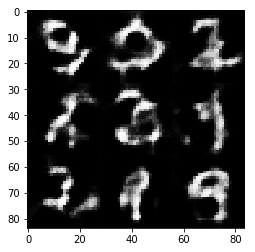

Epoch 1/2... Discriminator Loss: 1.0427... Generator Loss: 0.8788
Epoch 1/2... Discriminator Loss: 1.1142... Generator Loss: 0.8400
Epoch 1/2... Discriminator Loss: 1.0145... Generator Loss: 0.8516
Epoch 1/2... Discriminator Loss: 1.0957... Generator Loss: 0.8027
Epoch 1/2... Discriminator Loss: 1.0912... Generator Loss: 0.8640
Epoch 1/2... Discriminator Loss: 1.0918... Generator Loss: 0.8216
Epoch 1/2... Discriminator Loss: 1.0569... Generator Loss: 0.9125
Epoch 1/2... Discriminator Loss: 1.0038... Generator Loss: 0.9383
Epoch 1/2... Discriminator Loss: 1.1114... Generator Loss: 0.8095
Epoch 1/2... Discriminator Loss: 1.0096... Generator Loss: 0.9949


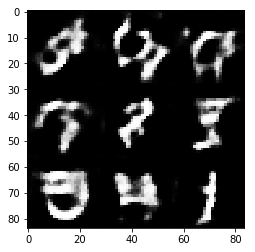

Epoch 1/2... Discriminator Loss: 1.0259... Generator Loss: 0.8766
Epoch 1/2... Discriminator Loss: 1.1982... Generator Loss: 0.8106
Epoch 1/2... Discriminator Loss: 1.1375... Generator Loss: 0.8082
Epoch 1/2... Discriminator Loss: 1.1078... Generator Loss: 0.7917
Epoch 1/2... Discriminator Loss: 1.1111... Generator Loss: 0.7776
Epoch 1/2... Discriminator Loss: 1.1307... Generator Loss: 0.7879
Epoch 1/2... Discriminator Loss: 1.0555... Generator Loss: 1.1184
Epoch 1/2... Discriminator Loss: 1.0217... Generator Loss: 0.9365
Epoch 1/2... Discriminator Loss: 1.0551... Generator Loss: 0.8709
Epoch 1/2... Discriminator Loss: 1.2090... Generator Loss: 0.6193


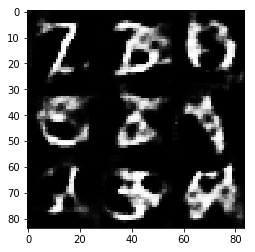

Epoch 1/2... Discriminator Loss: 1.2969... Generator Loss: 0.7934
Epoch 1/2... Discriminator Loss: 1.0562... Generator Loss: 0.9524
Epoch 1/2... Discriminator Loss: 1.0602... Generator Loss: 1.0017
Epoch 2/2... Discriminator Loss: 1.0853... Generator Loss: 0.8532
Epoch 2/2... Discriminator Loss: 1.1822... Generator Loss: 0.7857
Epoch 2/2... Discriminator Loss: 1.1762... Generator Loss: 0.7930
Epoch 2/2... Discriminator Loss: 1.1904... Generator Loss: 0.8236
Epoch 2/2... Discriminator Loss: 1.1814... Generator Loss: 0.8157
Epoch 2/2... Discriminator Loss: 1.1756... Generator Loss: 0.8275
Epoch 2/2... Discriminator Loss: 1.0730... Generator Loss: 0.9095


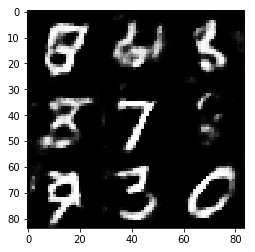

Epoch 2/2... Discriminator Loss: 1.1063... Generator Loss: 0.9090
Epoch 2/2... Discriminator Loss: 1.1308... Generator Loss: 0.8262
Epoch 2/2... Discriminator Loss: 1.1513... Generator Loss: 0.8895
Epoch 2/2... Discriminator Loss: 1.0890... Generator Loss: 0.8088
Epoch 2/2... Discriminator Loss: 1.1328... Generator Loss: 0.9421
Epoch 2/2... Discriminator Loss: 1.1200... Generator Loss: 0.8695
Epoch 2/2... Discriminator Loss: 1.1428... Generator Loss: 0.8306
Epoch 2/2... Discriminator Loss: 1.2817... Generator Loss: 0.5785
Epoch 2/2... Discriminator Loss: 1.1680... Generator Loss: 0.7739
Epoch 2/2... Discriminator Loss: 1.2348... Generator Loss: 0.7536


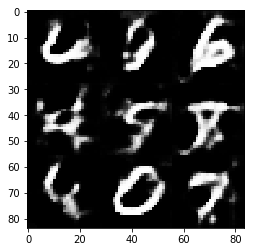

Epoch 2/2... Discriminator Loss: 1.2044... Generator Loss: 0.8008
Epoch 2/2... Discriminator Loss: 1.1210... Generator Loss: 0.8097
Epoch 2/2... Discriminator Loss: 1.1187... Generator Loss: 0.9228
Epoch 2/2... Discriminator Loss: 1.1293... Generator Loss: 0.7658
Epoch 2/2... Discriminator Loss: 1.1648... Generator Loss: 0.7301
Epoch 2/2... Discriminator Loss: 1.1768... Generator Loss: 0.8270
Epoch 2/2... Discriminator Loss: 1.1885... Generator Loss: 0.9654
Epoch 2/2... Discriminator Loss: 1.1657... Generator Loss: 0.8356
Epoch 2/2... Discriminator Loss: 1.2638... Generator Loss: 0.7590
Epoch 2/2... Discriminator Loss: 1.1869... Generator Loss: 0.8865


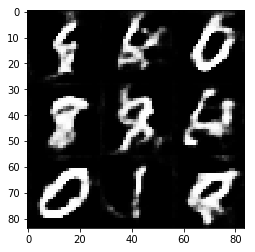

Epoch 2/2... Discriminator Loss: 1.2565... Generator Loss: 0.8917
Epoch 2/2... Discriminator Loss: 1.2214... Generator Loss: 0.8092
Epoch 2/2... Discriminator Loss: 1.2211... Generator Loss: 0.7459
Epoch 2/2... Discriminator Loss: 1.1841... Generator Loss: 0.7632
Epoch 2/2... Discriminator Loss: 1.2538... Generator Loss: 0.7744
Epoch 2/2... Discriminator Loss: 1.2179... Generator Loss: 0.7002
Epoch 2/2... Discriminator Loss: 1.2150... Generator Loss: 0.8429
Epoch 2/2... Discriminator Loss: 1.1829... Generator Loss: 0.7240
Epoch 2/2... Discriminator Loss: 1.0933... Generator Loss: 1.0123
Epoch 2/2... Discriminator Loss: 1.0999... Generator Loss: 0.9102


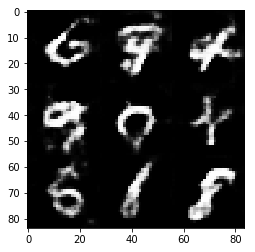

Epoch 2/2... Discriminator Loss: 1.1295... Generator Loss: 0.8586
Epoch 2/2... Discriminator Loss: 1.2270... Generator Loss: 0.8507
Epoch 2/2... Discriminator Loss: 1.2209... Generator Loss: 0.7794
Epoch 2/2... Discriminator Loss: 1.1556... Generator Loss: 0.8478
Epoch 2/2... Discriminator Loss: 1.2609... Generator Loss: 0.7928
Epoch 2/2... Discriminator Loss: 1.1357... Generator Loss: 0.8625
Epoch 2/2... Discriminator Loss: 1.2297... Generator Loss: 0.8193
Epoch 2/2... Discriminator Loss: 1.1268... Generator Loss: 0.8191
Epoch 2/2... Discriminator Loss: 1.1346... Generator Loss: 0.9111
Epoch 2/2... Discriminator Loss: 1.1617... Generator Loss: 0.8148


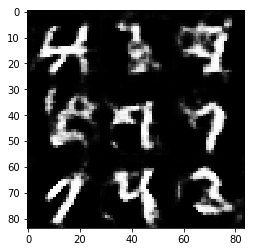

Epoch 2/2... Discriminator Loss: 1.1634... Generator Loss: 0.9066
Epoch 2/2... Discriminator Loss: 1.1963... Generator Loss: 0.7861
Epoch 2/2... Discriminator Loss: 1.1587... Generator Loss: 0.8989
Epoch 2/2... Discriminator Loss: 1.1006... Generator Loss: 1.0181
Epoch 2/2... Discriminator Loss: 1.1841... Generator Loss: 0.8818
Epoch 2/2... Discriminator Loss: 1.1851... Generator Loss: 0.6025
Epoch 2/2... Discriminator Loss: 1.0949... Generator Loss: 0.8635
Epoch 2/2... Discriminator Loss: 1.2139... Generator Loss: 0.7898
Epoch 2/2... Discriminator Loss: 1.2661... Generator Loss: 0.8555
Epoch 2/2... Discriminator Loss: 1.2721... Generator Loss: 0.8798


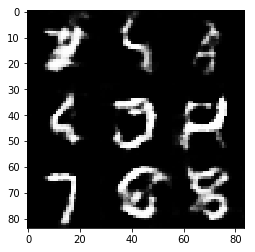

Epoch 2/2... Discriminator Loss: 1.1006... Generator Loss: 0.8671
Epoch 2/2... Discriminator Loss: 1.1750... Generator Loss: 0.8266
Epoch 2/2... Discriminator Loss: 1.2662... Generator Loss: 0.6842
Epoch 2/2... Discriminator Loss: 1.2840... Generator Loss: 0.6851
Epoch 2/2... Discriminator Loss: 1.1508... Generator Loss: 0.7239
Epoch 2/2... Discriminator Loss: 1.1820... Generator Loss: 0.9361
Epoch 2/2... Discriminator Loss: 1.1425... Generator Loss: 0.9093
Epoch 2/2... Discriminator Loss: 1.2330... Generator Loss: 0.7859
Epoch 2/2... Discriminator Loss: 1.2392... Generator Loss: 0.7009
Epoch 2/2... Discriminator Loss: 1.1645... Generator Loss: 0.7247


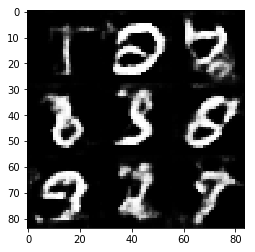

Epoch 2/2... Discriminator Loss: 1.1555... Generator Loss: 0.7557
Epoch 2/2... Discriminator Loss: 1.2508... Generator Loss: 0.7431
Epoch 2/2... Discriminator Loss: 1.0936... Generator Loss: 0.9611
Epoch 2/2... Discriminator Loss: 1.2371... Generator Loss: 0.8417
Epoch 2/2... Discriminator Loss: 1.2391... Generator Loss: 0.8910
Epoch 2/2... Discriminator Loss: 1.2712... Generator Loss: 0.7161
Epoch 2/2... Discriminator Loss: 1.2429... Generator Loss: 0.6408
Epoch 2/2... Discriminator Loss: 1.1837... Generator Loss: 0.7703
Epoch 2/2... Discriminator Loss: 1.2861... Generator Loss: 0.6783
Epoch 2/2... Discriminator Loss: 1.1208... Generator Loss: 0.7947


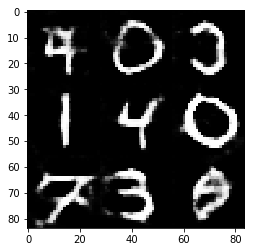

Epoch 2/2... Discriminator Loss: 1.2473... Generator Loss: 0.7966
Epoch 2/2... Discriminator Loss: 1.1943... Generator Loss: 0.8274
Epoch 2/2... Discriminator Loss: 1.1380... Generator Loss: 0.9738
Epoch 2/2... Discriminator Loss: 1.2339... Generator Loss: 0.7351
Epoch 2/2... Discriminator Loss: 1.1605... Generator Loss: 0.8564
Epoch 2/2... Discriminator Loss: 1.1424... Generator Loss: 0.7206
Epoch 2/2... Discriminator Loss: 1.2737... Generator Loss: 0.8326
Epoch 2/2... Discriminator Loss: 1.1043... Generator Loss: 0.8016
Epoch 2/2... Discriminator Loss: 1.2913... Generator Loss: 0.7340
Epoch 2/2... Discriminator Loss: 1.2104... Generator Loss: 0.7324


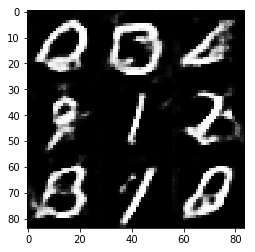

Epoch 2/2... Discriminator Loss: 1.3149... Generator Loss: 0.6623
Epoch 2/2... Discriminator Loss: 1.2008... Generator Loss: 0.7472
Epoch 2/2... Discriminator Loss: 1.1696... Generator Loss: 0.8161
Epoch 2/2... Discriminator Loss: 1.2099... Generator Loss: 0.7822
Epoch 2/2... Discriminator Loss: 1.2546... Generator Loss: 0.7849
Epoch 2/2... Discriminator Loss: 1.2100... Generator Loss: 0.7734
Epoch 2/2... Discriminator Loss: 1.2746... Generator Loss: 0.7044


In [14]:
batch_size = 64 #128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.0421... Generator Loss: 4.4863
Epoch 1/1... Discriminator Loss: 0.0044... Generator Loss: 8.5429
Epoch 1/1... Discriminator Loss: 0.0232... Generator Loss: 4.2668
Epoch 1/1... Discriminator Loss: 0.0110... Generator Loss: 5.4888
Epoch 1/1... Discriminator Loss: 0.0049... Generator Loss: 7.6958
Epoch 1/1... Discriminator Loss: 0.0126... Generator Loss: 4.8904
Epoch 1/1... Discriminator Loss: 0.0218... Generator Loss: 6.3540
Epoch 1/1... Discriminator Loss: 0.0272... Generator Loss: 3.8802
Epoch 1/1... Discriminator Loss: 0.0501... Generator Loss: 3.7797
Epoch 1/1... Discriminator Loss: 0.0199... Generator Loss: 4.9565


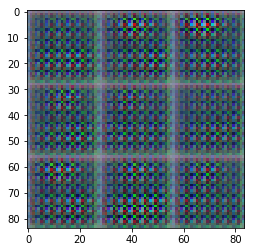

Epoch 1/1... Discriminator Loss: 0.4122... Generator Loss: 13.2917
Epoch 1/1... Discriminator Loss: 0.0974... Generator Loss: 3.5870
Epoch 1/1... Discriminator Loss: 0.1346... Generator Loss: 2.6614
Epoch 1/1... Discriminator Loss: 0.9764... Generator Loss: 1.3377
Epoch 1/1... Discriminator Loss: 0.8483... Generator Loss: 1.0372
Epoch 1/1... Discriminator Loss: 1.2351... Generator Loss: 0.5929
Epoch 1/1... Discriminator Loss: 0.5718... Generator Loss: 2.8522
Epoch 1/1... Discriminator Loss: 0.3929... Generator Loss: 1.9636
Epoch 1/1... Discriminator Loss: 1.4654... Generator Loss: 0.5887
Epoch 1/1... Discriminator Loss: 0.8060... Generator Loss: 0.8386


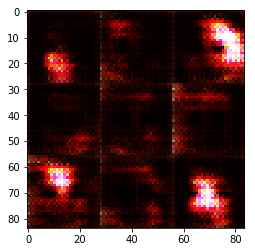

Epoch 1/1... Discriminator Loss: 0.5023... Generator Loss: 1.4315
Epoch 1/1... Discriminator Loss: 0.2275... Generator Loss: 2.5636
Epoch 1/1... Discriminator Loss: 0.4718... Generator Loss: 4.7723
Epoch 1/1... Discriminator Loss: 0.1699... Generator Loss: 2.9030
Epoch 1/1... Discriminator Loss: 0.1635... Generator Loss: 3.2714
Epoch 1/1... Discriminator Loss: 0.1048... Generator Loss: 2.8594
Epoch 1/1... Discriminator Loss: 0.0374... Generator Loss: 5.2816
Epoch 1/1... Discriminator Loss: 0.4063... Generator Loss: 2.2951
Epoch 1/1... Discriminator Loss: 4.2170... Generator Loss: 11.4969
Epoch 1/1... Discriminator Loss: 0.4182... Generator Loss: 1.3534


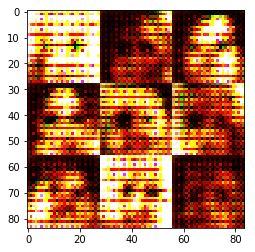

Epoch 1/1... Discriminator Loss: 0.2066... Generator Loss: 2.8439
Epoch 1/1... Discriminator Loss: 0.1602... Generator Loss: 2.9717
Epoch 1/1... Discriminator Loss: 0.1213... Generator Loss: 2.7966
Epoch 1/1... Discriminator Loss: 0.2589... Generator Loss: 1.9758
Epoch 1/1... Discriminator Loss: 0.0568... Generator Loss: 3.6059
Epoch 1/1... Discriminator Loss: 0.2469... Generator Loss: 3.1028
Epoch 1/1... Discriminator Loss: 0.2909... Generator Loss: 1.9883
Epoch 1/1... Discriminator Loss: 0.1742... Generator Loss: 2.6591
Epoch 1/1... Discriminator Loss: 0.1859... Generator Loss: 2.3856
Epoch 1/1... Discriminator Loss: 0.1904... Generator Loss: 3.0156


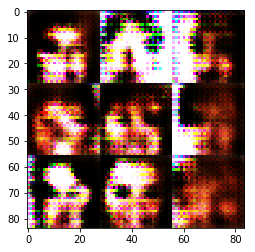

Epoch 1/1... Discriminator Loss: 0.2806... Generator Loss: 2.0906
Epoch 1/1... Discriminator Loss: 0.3529... Generator Loss: 1.7342
Epoch 1/1... Discriminator Loss: 0.5535... Generator Loss: 4.5926
Epoch 1/1... Discriminator Loss: 0.9384... Generator Loss: 0.6700
Epoch 1/1... Discriminator Loss: 0.8252... Generator Loss: 1.4009
Epoch 1/1... Discriminator Loss: 0.6980... Generator Loss: 1.6806
Epoch 1/1... Discriminator Loss: 0.4002... Generator Loss: 1.9985
Epoch 1/1... Discriminator Loss: 0.4080... Generator Loss: 1.6272
Epoch 1/1... Discriminator Loss: 0.5191... Generator Loss: 3.0626
Epoch 1/1... Discriminator Loss: 0.5000... Generator Loss: 1.4394


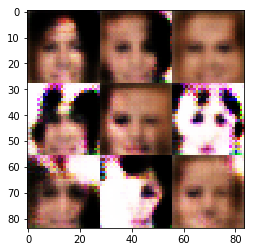

Epoch 1/1... Discriminator Loss: 0.6494... Generator Loss: 2.0549
Epoch 1/1... Discriminator Loss: 0.7948... Generator Loss: 0.8683
Epoch 1/1... Discriminator Loss: 0.7060... Generator Loss: 1.0630
Epoch 1/1... Discriminator Loss: 0.6221... Generator Loss: 1.2497
Epoch 1/1... Discriminator Loss: 0.9146... Generator Loss: 3.0537
Epoch 1/1... Discriminator Loss: 0.8577... Generator Loss: 0.8212
Epoch 1/1... Discriminator Loss: 0.7235... Generator Loss: 1.1634
Epoch 1/1... Discriminator Loss: 0.6197... Generator Loss: 1.3373
Epoch 1/1... Discriminator Loss: 0.4868... Generator Loss: 1.9758
Epoch 1/1... Discriminator Loss: 0.4815... Generator Loss: 1.3845


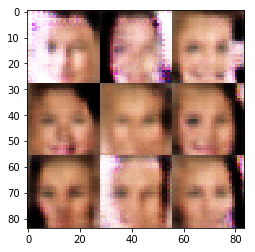

Epoch 1/1... Discriminator Loss: 1.2686... Generator Loss: 0.4922
Epoch 1/1... Discriminator Loss: 0.8149... Generator Loss: 1.5378
Epoch 1/1... Discriminator Loss: 0.4390... Generator Loss: 1.8032
Epoch 1/1... Discriminator Loss: 0.6023... Generator Loss: 1.3198
Epoch 1/1... Discriminator Loss: 0.8950... Generator Loss: 2.4561
Epoch 1/1... Discriminator Loss: 0.7015... Generator Loss: 1.0811
Epoch 1/1... Discriminator Loss: 0.7068... Generator Loss: 1.0751
Epoch 1/1... Discriminator Loss: 0.6437... Generator Loss: 1.1266
Epoch 1/1... Discriminator Loss: 0.3191... Generator Loss: 1.9253
Epoch 1/1... Discriminator Loss: 5.9431... Generator Loss: 5.0673


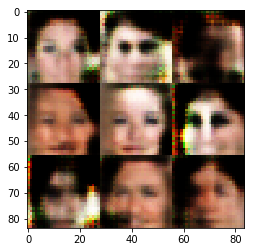

Epoch 1/1... Discriminator Loss: 0.9723... Generator Loss: 0.8314
Epoch 1/1... Discriminator Loss: 0.5238... Generator Loss: 1.8176
Epoch 1/1... Discriminator Loss: 0.3730... Generator Loss: 2.0998
Epoch 1/1... Discriminator Loss: 0.7332... Generator Loss: 1.0568
Epoch 1/1... Discriminator Loss: 0.4044... Generator Loss: 2.0656
Epoch 1/1... Discriminator Loss: 0.4130... Generator Loss: 1.7602
Epoch 1/1... Discriminator Loss: 0.2587... Generator Loss: 3.1280
Epoch 1/1... Discriminator Loss: 0.4223... Generator Loss: 3.7528
Epoch 1/1... Discriminator Loss: 0.8563... Generator Loss: 0.9437
Epoch 1/1... Discriminator Loss: 0.4350... Generator Loss: 1.9425


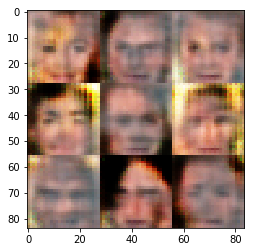

Epoch 1/1... Discriminator Loss: 0.8538... Generator Loss: 0.9583
Epoch 1/1... Discriminator Loss: 0.5959... Generator Loss: 1.2308
Epoch 1/1... Discriminator Loss: 1.5101... Generator Loss: 3.9203
Epoch 1/1... Discriminator Loss: 0.4861... Generator Loss: 2.4258
Epoch 1/1... Discriminator Loss: 0.6763... Generator Loss: 1.1861
Epoch 1/1... Discriminator Loss: 0.6782... Generator Loss: 1.0579
Epoch 1/1... Discriminator Loss: 2.1694... Generator Loss: 0.1793
Epoch 1/1... Discriminator Loss: 1.2679... Generator Loss: 2.2461
Epoch 1/1... Discriminator Loss: 0.8476... Generator Loss: 0.9647
Epoch 1/1... Discriminator Loss: 1.0412... Generator Loss: 0.7997


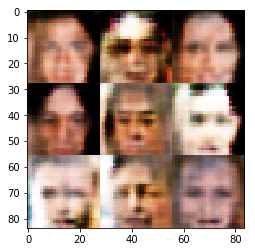

Epoch 1/1... Discriminator Loss: 0.6040... Generator Loss: 1.5541
Epoch 1/1... Discriminator Loss: 0.9303... Generator Loss: 2.0419
Epoch 1/1... Discriminator Loss: 0.7786... Generator Loss: 1.7978
Epoch 1/1... Discriminator Loss: 0.9079... Generator Loss: 0.7556
Epoch 1/1... Discriminator Loss: 0.6937... Generator Loss: 1.3863
Epoch 1/1... Discriminator Loss: 1.0795... Generator Loss: 1.0055
Epoch 1/1... Discriminator Loss: 0.8641... Generator Loss: 1.5061
Epoch 1/1... Discriminator Loss: 1.0321... Generator Loss: 0.7384
Epoch 1/1... Discriminator Loss: 0.5317... Generator Loss: 1.9834
Epoch 1/1... Discriminator Loss: 0.7288... Generator Loss: 1.5037


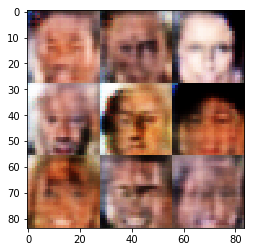

Epoch 1/1... Discriminator Loss: 0.9933... Generator Loss: 0.8745
Epoch 1/1... Discriminator Loss: 1.2666... Generator Loss: 0.5449
Epoch 1/1... Discriminator Loss: 1.3562... Generator Loss: 0.4854
Epoch 1/1... Discriminator Loss: 0.8882... Generator Loss: 1.1746
Epoch 1/1... Discriminator Loss: 0.9207... Generator Loss: 1.4581
Epoch 1/1... Discriminator Loss: 0.7180... Generator Loss: 1.6250
Epoch 1/1... Discriminator Loss: 1.0994... Generator Loss: 0.6067
Epoch 1/1... Discriminator Loss: 0.5983... Generator Loss: 1.6330
Epoch 1/1... Discriminator Loss: 1.2238... Generator Loss: 0.5785
Epoch 1/1... Discriminator Loss: 0.9311... Generator Loss: 0.8169


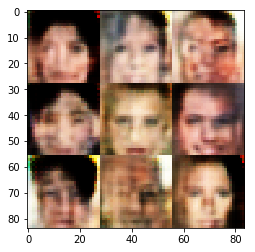

Epoch 1/1... Discriminator Loss: 1.0244... Generator Loss: 0.6378
Epoch 1/1... Discriminator Loss: 0.9769... Generator Loss: 1.5209
Epoch 1/1... Discriminator Loss: 1.2320... Generator Loss: 0.5609
Epoch 1/1... Discriminator Loss: 1.0204... Generator Loss: 0.8116
Epoch 1/1... Discriminator Loss: 1.0243... Generator Loss: 0.8988
Epoch 1/1... Discriminator Loss: 1.3166... Generator Loss: 0.4979
Epoch 1/1... Discriminator Loss: 0.8186... Generator Loss: 0.9648
Epoch 1/1... Discriminator Loss: 0.8658... Generator Loss: 0.9543
Epoch 1/1... Discriminator Loss: 1.2168... Generator Loss: 0.5313
Epoch 1/1... Discriminator Loss: 0.9197... Generator Loss: 1.0802


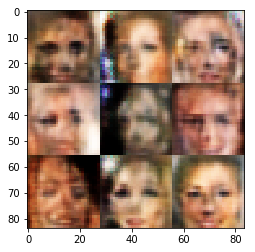

Epoch 1/1... Discriminator Loss: 1.4600... Generator Loss: 2.7760
Epoch 1/1... Discriminator Loss: 0.9284... Generator Loss: 1.2144
Epoch 1/1... Discriminator Loss: 0.9066... Generator Loss: 1.4910
Epoch 1/1... Discriminator Loss: 1.1997... Generator Loss: 0.5580
Epoch 1/1... Discriminator Loss: 1.3381... Generator Loss: 0.4729
Epoch 1/1... Discriminator Loss: 0.8827... Generator Loss: 0.7422
Epoch 1/1... Discriminator Loss: 0.7500... Generator Loss: 1.5465
Epoch 1/1... Discriminator Loss: 1.0436... Generator Loss: 0.9199
Epoch 1/1... Discriminator Loss: 1.0262... Generator Loss: 0.7665
Epoch 1/1... Discriminator Loss: 1.8327... Generator Loss: 0.2353


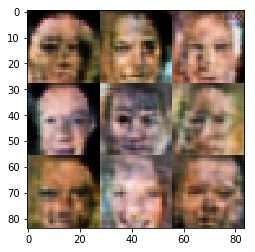

Epoch 1/1... Discriminator Loss: 1.0129... Generator Loss: 0.9362
Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 0.4306
Epoch 1/1... Discriminator Loss: 0.9936... Generator Loss: 0.9973
Epoch 1/1... Discriminator Loss: 0.9415... Generator Loss: 1.5785
Epoch 1/1... Discriminator Loss: 1.1413... Generator Loss: 0.5830
Epoch 1/1... Discriminator Loss: 1.2351... Generator Loss: 0.5139


KeyboardInterrupt: 

In [16]:
batch_size = 64 #128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.